In [1]:
import tensorflow as tf
import pickle 
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import random 
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
import csv
from zipfile import ZipFile 
import os
import sys
import glob
print(tf.__version__)

2.6.4


['HEM017', 'AH055', 'ICD30', 'ICD18', 'TE059', 'HA023', 'ICD21', 'ICD16', 'ICD22', 'HL064', 'GH053', 'TLH037', 'RS008', 'OJK047', 'THK034', 'ICD15', 'ICD42', 'ICD17', 'ORH024', 'JM011', 'ICD40', 'FOS018', 'ICD19', 'ST007', 'RS043', 'MK028', 'SGT044', 'ICD20', 'ICD31', 'PAK061', 'ICD28', 'SHL039', 'ICD38', 'RKG042']


2022-12-20 13:01:23.898835: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


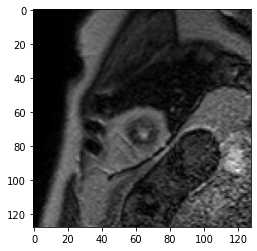

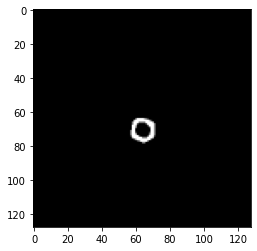

Min and max pixel values: 0.0 189.0
Min and max pixel values: 0.0 1.0


In [2]:
# Define param
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
PICKLE_PATH = '../input/cardio/pickle.p'

input_shape = (IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)

# Load data
with open(PICKLE_PATH, "rb") as input_file:
    data = pickle.load(input_file)
    
# Preprosess
ids = data.pop("id")
print(ids['train'])

for (key, value) in data.items():
    number, height, width = value.shape
    #print(height,width)
    if 'Mmyo' in key:
        value = value*255
    data[key] = value.reshape(number, height, width, IMG_CHANNELS)
    # print(f'\nkey:{key}, \nshape:{data[key].shape}')
 

    
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_WIDTH, IMG_HEIGHT),
    layers.Rescaling(1./255)
  
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

train_images = resize_and_rescale(data['train images'])
train_Mmyo = resize_and_rescale(data['train Mmyo'])

test_images = resize_and_rescale(data['test images'])
test_Mmyo = resize_and_rescale(data['test Mmyo'])

validation_images = resize_and_rescale(data['validation images'])
validation_Mmyo = resize_and_rescale(data['validation Mmyo'])


#train_images = data_augmentation(train_images)
#train_Mmyo = data_augmentation(train_Mmyo)

plt.figure(3)
plt.imshow(train_images[0], cmap='gray')
plt.figure(4)
plt.imshow(train_Mmyo[0], cmap='gray')
plt.show()

print("Min and max pixel values:", data['train images'][0].min(), data['train images'][0].max())
print("Min and max pixel values:", train_Mmyo[0].numpy().min(), train_Mmyo[0].numpy().max())


In [3]:
def create_unet_model(input_shape):
    #Buildeing an unet model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(c6)
    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(c7)
    
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(c8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), padding='same')(c9)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name = "UNet_Model")

    return model

In [4]:
def wce(beta):
    """
    This function is extracted from Lars' Blog url:
    https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
    """
    def loss(y_true, y_pred):
        weight_a = beta * tf.cast(y_true, tf.float32)
        weight_b = 1 - tf.cast(y_true, tf.float32)

        o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b 
        return tf.reduce_mean(o)

    return loss

def focal_loss(alpha=0.25, gamma=2):
    """
    Extracted from Lars's Blog: 
    https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
    """
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        targets = tf.cast(targets, tf.float32)
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

    def loss(y_true, logits):
        y_pred = tf.math.sigmoid(logits)
        loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

        return tf.reduce_mean(loss)

    return loss

In [5]:
Mmyo_percentage = np.ceil(train_Mmyo.numpy()).sum()/train_Mmyo.numpy().size

print(1/Mmyo_percentage)
print(Mmyo_percentage)

26.200337199202984
0.03816744770866613


In [25]:
train = False
if train:
    unet_model = create_unet_model(input_shape)
    name = 'val_accuracy'
    unet_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=wce(1/Mmyo_percentage)
    , metrics=['accuracy',
          tf.keras.metrics.TruePositives(name='tp'), 
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.PrecisionAtRecall(recall=0.9, name='Prec_at_Re'),
          tf.keras.metrics.AUC(name='AUC_ROC',curve='ROC'),
          tf.keras.metrics.AUC(name='AUC_PR',curve='PR')]
                      )
    # unet_model.summary()
    # tf.keras.utils.plot_model(unet_model,)

    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=15, monitor=name, mode='max', restore_best_weights=True,verbose=1),    
            tf.keras.callbacks.ModelCheckpoint(f'{name}.h5', mode='max',monitor=name, verbose=1, save_best_only=True)
            ]
    #

    result = unet_model.fit(
        x = train_images,
        y = train_Mmyo,
        epochs=300, 
        validation_data = (validation_images, validation_Mmyo),
        validation_steps = 1, 
        batch_size = 10,
        steps_per_epoch = len(train_images)//10,
        verbose=1,
        callbacks = callbacks    
        )
# ,

In [13]:
def dice(output, target):
    #output, target = output.data.cpu(), target.data.cpu()
    npoutput, nptarget = output, target

    npoutput = npoutput.flatten()
    nptarget = nptarget.flatten()

    intersection = np.logical_and(nptarget, npoutput)
    A = np.sum(npoutput)
    B = np.sum(nptarget)

    dice = 2 * (intersection.sum() + 1) / (A + B + 1)

    return dice

In [18]:
def pred_and_plot(unet_model, test_images, test_Mmyo,title,save_path=None,random_samples=False):

    preds_test = unet_model.predict(test_images, verbose=0)
    
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    if random_samples:
        a = [i for i in range(len(preds_test_t))]
        ix = np.random.choice(a,size=5,replace=False)
    #print(f'ix: {ix}')
    else:
        ix = [6, 86, 114, 96, 98]
    fig = plt.figure(figsize=(30,12))
    
    alpha = 0.5  # Transparency factor
    for n, i in enumerate(ix,1):
        # Add contours from ground truth
        rgb = cv2.cvtColor((test_images[i]*255).numpy().astype(np.uint8),cv2.COLOR_GRAY2RGB)
        cont, _ = cv2.findContours(test_Mmyo[i].numpy().astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        img_cont = cv2.drawContours(rgb.copy(), cont, -1,(0,255,79),-1)
        img_cont = cv2.addWeighted(img_cont, alpha,rgb.copy() , 1 - alpha, 0)
        img_cont = cv2.drawContours(img_cont,cont,-2,(255,0,0),1)
        
        # Add contours from predicted myocardium
        pred_cont, _ = cv2.findContours(preds_test_t[i], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        img_pred_cont = cv2.drawContours(rgb.copy(),pred_cont,-2,(0,255,79),-1)
        img_pred_cont = cv2.addWeighted(img_pred_cont, alpha,rgb.copy() , 1 - alpha, 0)
        img_pred_cont = cv2.drawContours(img_pred_cont,pred_cont,-1,(255,0,0),1)
        
        plt.subplot(2,5,n)
        if n ==3:
            plt.title('Original Images with Myocardium Mask',fontsize=40)
        plt.imshow(img_cont)
        
        plt.subplot(2,5,5+n)
        if n==3:
            plt.title(f'Predicted Masks, {title}',fontsize=40)
        plt.imshow(img_pred_cont)

        for ax in fig.axes:
            ax.axis('off')
        if save_path is not None:
            plt.savefig(save_path)
    plt.show()

[Errno 17] File exists: '/kaggle/working/Mmyo_images'


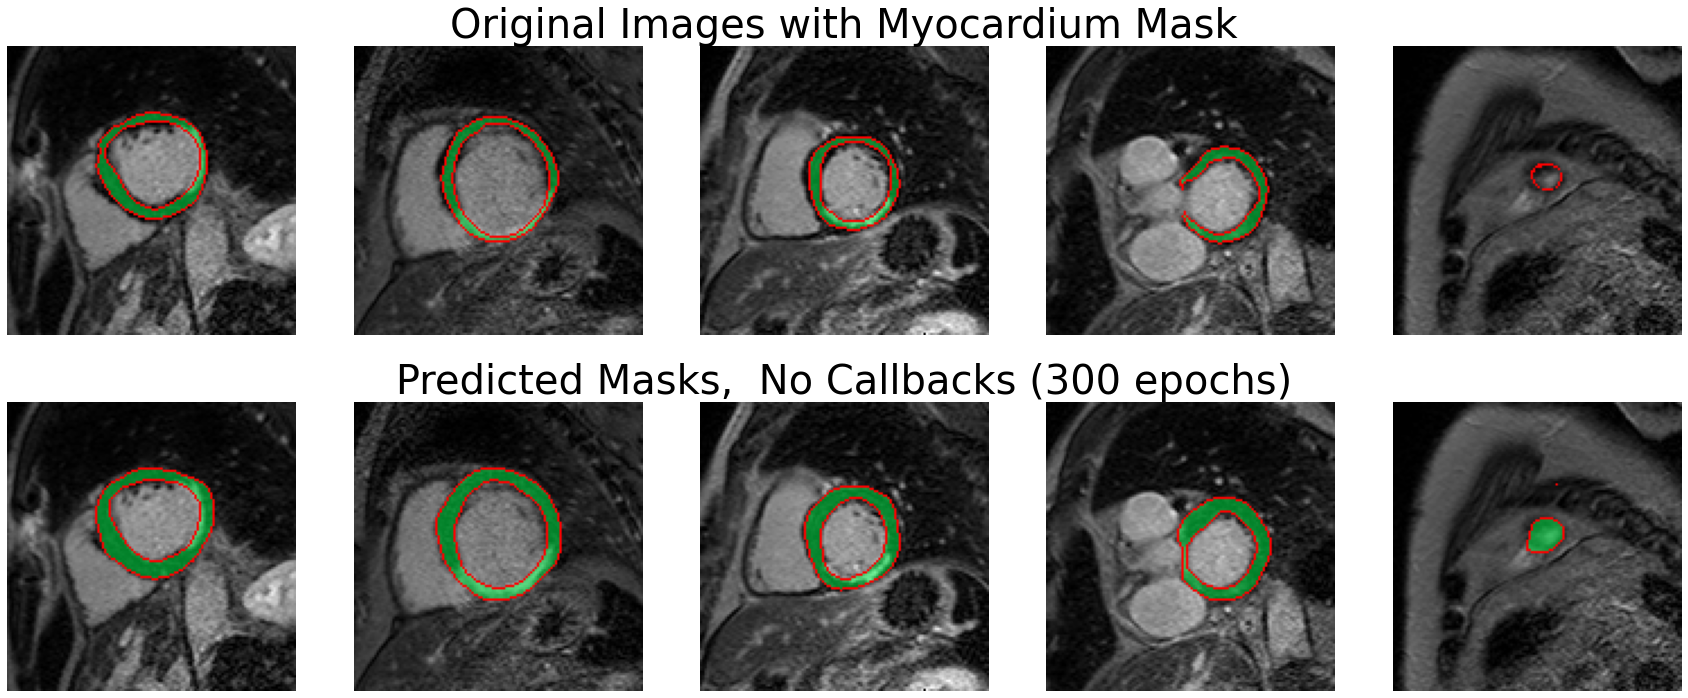

['/kaggle/input/wce-metrics/Full_300_epochs/full300.h5']


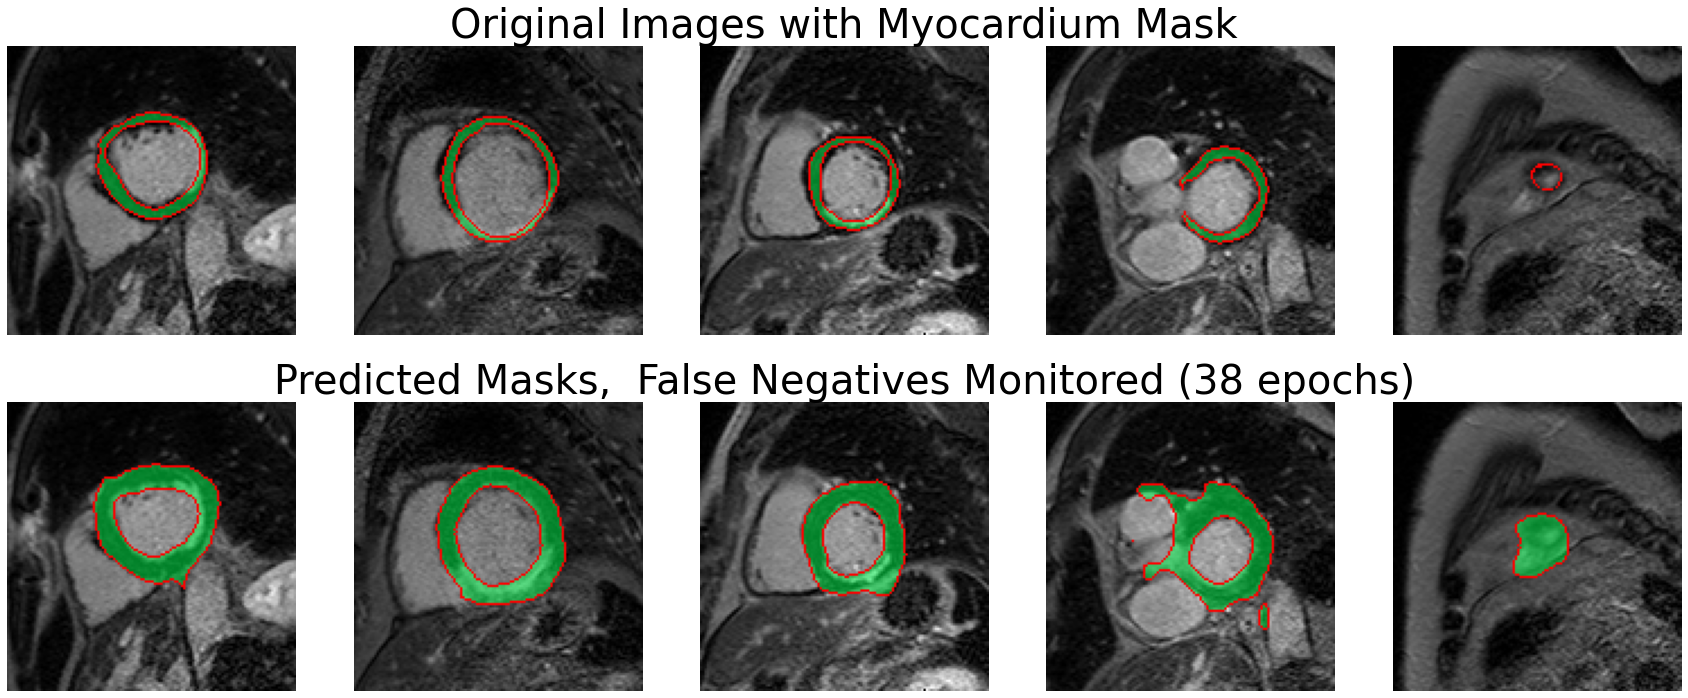

['/kaggle/input/wce-metrics/val_fn/val_recall.h5']


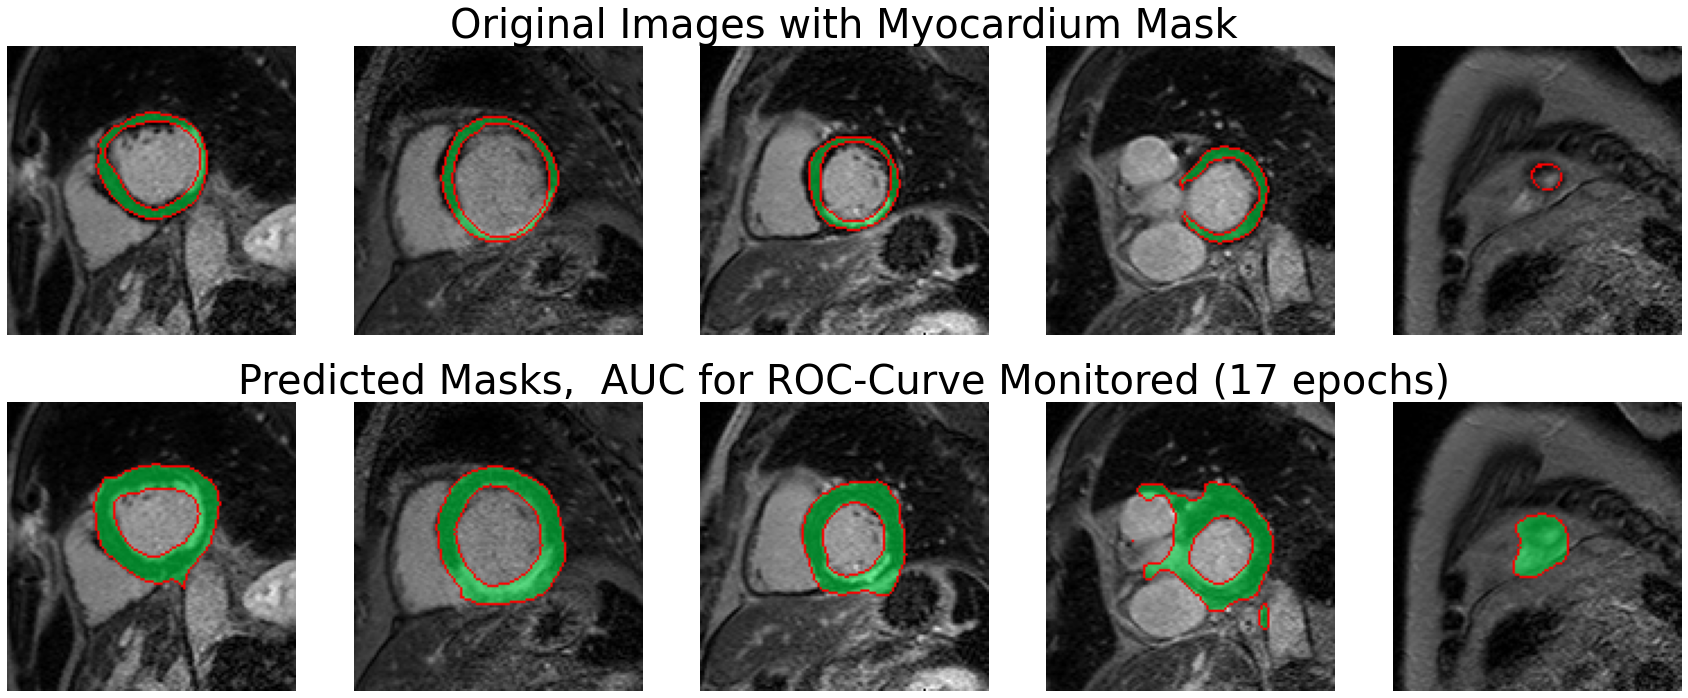

['/kaggle/input/wce-metrics/val_AUC_ROC/val_recall.h5']


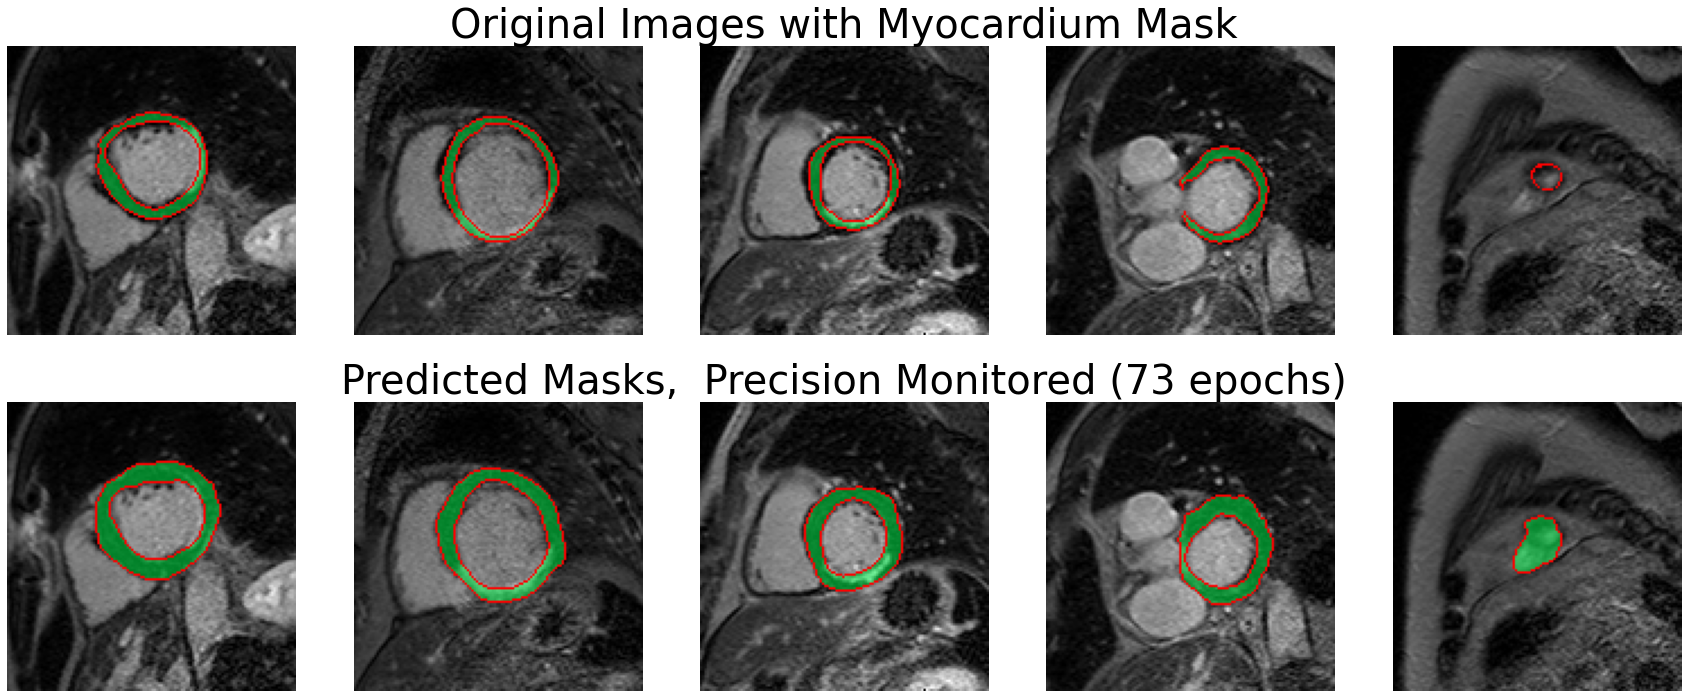

['/kaggle/input/wce-metrics/val_precision/precision.h5']


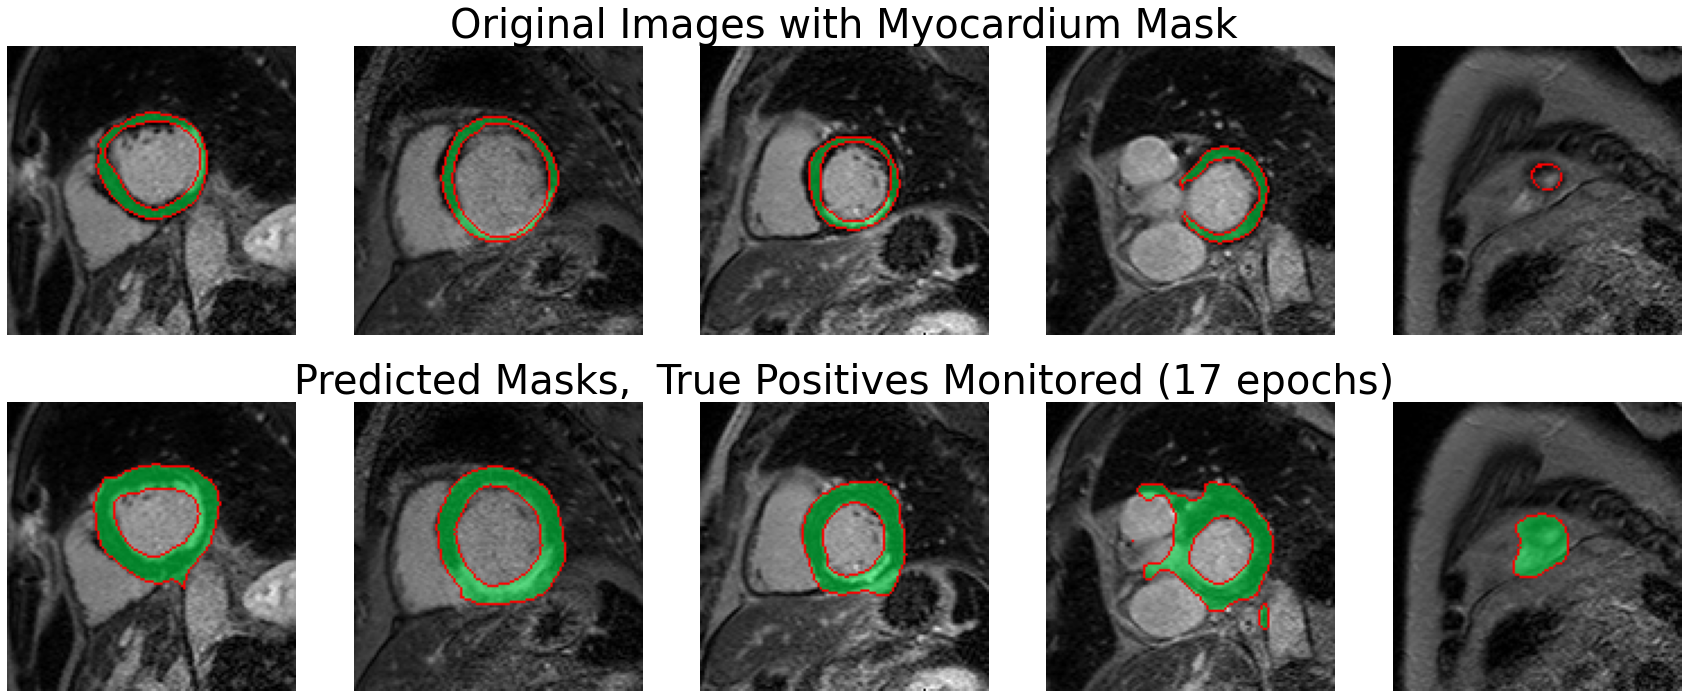

['/kaggle/input/wce-metrics/val_tp/val_recall.h5']


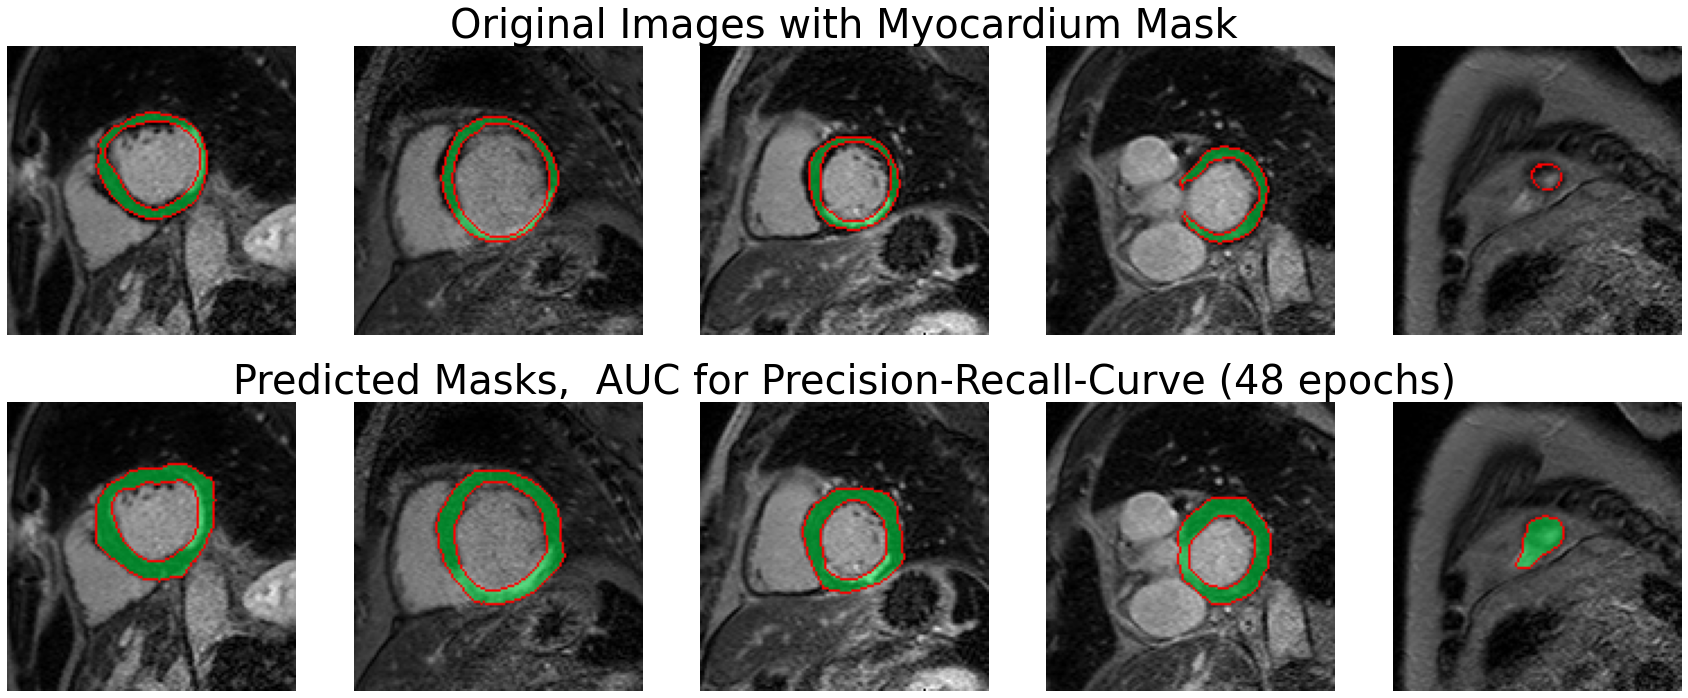

['/kaggle/input/wce-metrics/val_AUC_PR/val_AUC_PR.h5']


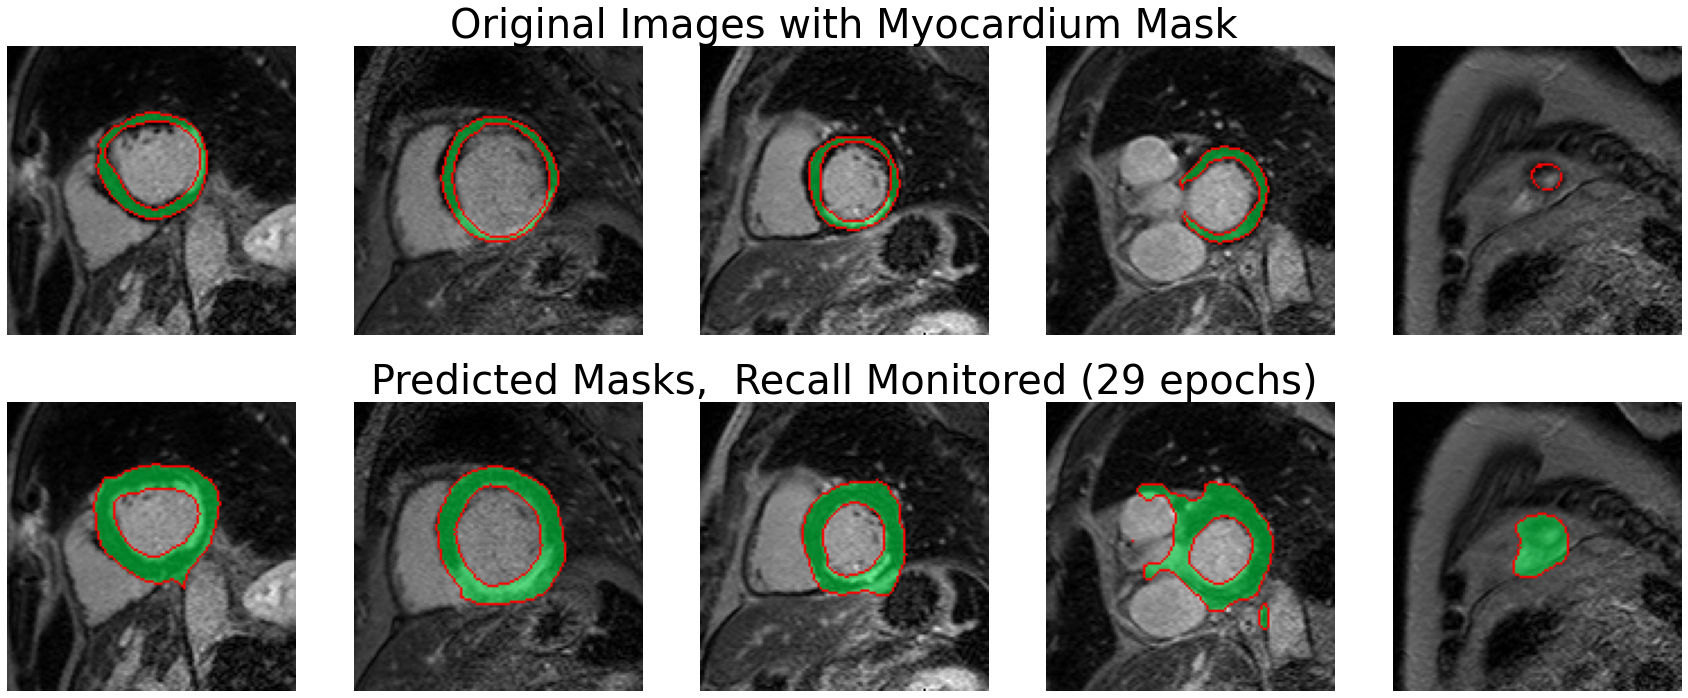

['/kaggle/input/wce-metrics/val_recall/val_recall.h5']


In [19]:
# Run this after all models have been trained and saved in
# pickle-files and .h5 files.
path_to_saved_images = '/kaggle/working/Mmyo_images' 
try:
    os.mkdir(path_to_saved_images) 
except OSError as error:
    print(error)
    
path = '/kaggle/input/wce-metrics'
save_path = '/kaggle/working/Mmyo_images'
metrics = os.listdir(path)
title_dict = {'Full_300_epochs':' No Callbacks', 'val_fn':' False Negatives Monitored',
             'val_AUC_ROC':' AUC for ROC-Curve Monitored', 'val_precision':' Precision Monitored',
             'val_recall':' Recall Monitored', 'val_tp':' True Positives Monitored',
             'val_AUC_PR':' AUC for Precision-Recall-Curve',}
pickle_dicts = {}
for i, folder in enumerate(metrics):
    
    h5_file = glob.glob(f'{path}/{folder}/*.h5')
    pickle_file = glob.glob(f'{path}/{folder}/*.p')
    with open(pickle_file[0],'rb') as p:
        epochs = pickle.load(p)['info'].split(',')[-1].strip() # loads dict, get info
    unet_model = create_unet_model(input_shape)
    unet_model.load_weights(h5_file[0])
    pred_and_plot(unet_model, test_images, test_Mmyo,f'{title_dict[folder]} ({epochs})',
                 f'{save_path}/{folder.replace("val_","")}.png')


In [22]:
from sklearn.metrics import f1_score
# These functions are from A.Kregnes, and have been modified slightly due to the differences in formatting bewteen the projects
def F1(output, target):
    npoutput, nptarget = output.astype(bool), target.numpy().astype(bool)
    nptarget = nptarget.flatten()
    npoutput = npoutput.flatten()

    f1 = f1_score(nptarget, npoutput, average=None)
    return f1

def jaccard(output, target):
    npoutput, nptarget = output.astype(bool), target.numpy().astype(bool)

    intersection = np.logical_and(npoutput, nptarget)
    union = np.logical_or(npoutput, nptarget)
    jacc = intersection.sum() / float(union.sum())
    return jacc

In [23]:
header = ['callback','Precision', 'Recall', 'Dice', 'Jaccard','F1-score']
rows = []
for i, folder in enumerate(metrics):
    perf_dict = {}
    h5_file = glob.glob(f'{path}/{folder}/*.h5')[0]
    unet_model = create_unet_model(input_shape)
    unet_model.load_weights(h5_file)

    preds_test = unet_model.predict(test_images, verbose=0)
    preds_test_t = (preds_test > 0.5)
    test_Mmyo_flat = test_Mmyo.numpy().astype(np.bool_).flatten()
    prediction_flat = preds_test_t.flatten()
    print(title_dict[folder])
    print(f'Precision: {round(precision_score(test_Mmyo_flat, prediction_flat),3)}')
    print(f'Recall: {round(recall_score(test_Mmyo_flat, prediction_flat),3)}')
    print(f'Dice: {round(dice(preds_test_t, test_Mmyo.numpy()),3)}')
    print(f'Jaccard: {round(jaccard(preds_test_t, test_Mmyo),3)}')
    print(f'F1-score: {np.round(np.array(F1(preds_test_t, test_Mmyo)),3)}')
    print('---------------------------------')


 No Callbacks
Precision: 0.731
Recall: 0.93
Dice: 0.868
Jaccard: 0.693
F1-score: [0.993 0.819]
---------------------------------
 False Negatives Monitored
Precision: 0.413
Recall: 0.99
Dice: 0.606
Jaccard: 0.411
F1-score: [0.975 0.583]
---------------------------------
 AUC for ROC-Curve Monitored
Precision: 0.413
Recall: 0.99
Dice: 0.606
Jaccard: 0.411
F1-score: [0.975 0.583]
---------------------------------
 Precision Monitored
Precision: 0.657
Recall: 0.937
Dice: 0.815
Jaccard: 0.629
F1-score: [0.991 0.772]
---------------------------------
 True Positives Monitored
Precision: 0.413
Recall: 0.99
Dice: 0.606
Jaccard: 0.411
F1-score: [0.975 0.583]
---------------------------------
 AUC for Precision-Recall-Curve
Precision: 0.624
Recall: 0.96
Dice: 0.797
Jaccard: 0.608
F1-score: [0.989 0.757]
---------------------------------
 Recall Monitored
Precision: 0.413
Recall: 0.99
Dice: 0.606
Jaccard: 0.411
F1-score: [0.975 0.583]
---------------------------------
